# Group: 27
### Submission: 03
### Devs:
    Vivek Verma: Q1
    Harshil Sumra: Q2, 3, 4
    Christian Chihababo: Q5
<hr>

#### Following are the paramters used for the compute question below:
|Symbol|Description|Value|
|-|-|-|
|T|Option Maturity|1.0|
|S0|Current Stock Price|100.0|
|K|Strike Price - At-the-money|100.0|
|v|Initial volatility|0.30|
|r|Risk-free interest rate|0.08|
|B_uo|Barrier Up and Out Level|150.0|
|S_cp|Current Counter party firm value|200.0|
|K_cp|Counter party debt|175.0|
|v_cp|Initial volatility of counter party|0.30|
|corr_cp_stk|Correlation between counter party and the stock|0.20|
|rr|Recovery rate with counter party|0.25|
|gamma|Gamma|0.75|



In [2]:
import numpy as np
from scipy.stats import norm
import scipy.optimize
import matplotlib.pyplot as plt
import pandas as pd

## 1. Jointly simulate monthly LIBOR forward rates, stock paths and Counterparty firm values, with sample size of 1000000.

In [24]:
# option params
S0 = 100.0
v = 0.30
r = 0.08
T = 1.0
K = 100.0
B_uo = 150.0
months = 12 * int(T)
delta_t = T / months
gamma = 0.75

# counterparty firm params
S_cp = 200.0
v_cp = 0.30
K_cp = 175.0
Debt = 175.0
corr_cp_stk = 0.20
rr = 0.25

np.random.seed(0)

In [4]:
def calc_d1(S0, K, r, vol, T):
    """Function to calculate d1"""
    return (np.log(S0 / K) + (r + .5 * vol ** 2) * T) / (vol * np.sqrt(T))


def calc_d2(d1, vol, T):
    """Function to calculate d2"""
    return d1 - vol * np.sqrt(T)


def calc_cdf(val):
    """Function to calculate cumulative distributive function using scipy norm pkg"""
    return norm.cdf(val)


def calc_price_call(S0, r, T, vol, K, verbose=False):
    """Function to calculate price of Call option"""
    d1 = calc_d1(S0, K, r, vol, T)
    d2 = calc_d2(d1, vol, T)
    if verbose: print(f"d1: {d1}; d2: {d2}")
    price = S0 * calc_cdf(d1) - K * np.exp(-r * T) * calc_cdf(d2)  # compute price using all input and variables
    if verbose: print(f"Call option price: {price}, with a standard deviation of {vol} for time {T} and S0={S0} & K={K}")
    return price


def calc_A(t1, t2, alpha):
    return (1 - np.exp(-alpha * (t2 - t1))) / alpha


def calc_D(t1, t2, alpha, b, sigma):
    val1 = (t2 - t1 - calc_A(t1, t2, alpha)) * (sigma ** 2 / (2 * alpha ** 2) - b)
    val2 = sigma ** 2 * calc_A(t1, t2, alpha) ** 2 / (4 * alpha)
    return val1 - val2


def calc_bond_price(r, t, T, alpha, b, sigma):
    return np.exp(-calc_A(t, T, alpha) * r + calc_D(t, T, alpha, b, sigma))


def calc_F(x):
    r0 = x[0]
    alpha = x[1]
    b = x[2]
    sigma = x[3]
    return np.sum(np.abs(calc_bond_price(r0, 0, maturity, alpha, b, sigma) - zcb_prices))


In [5]:
_ = calc_price_call(S0, r, T, v, K, verbose=True)


d1: 0.4166666666666667; d2: 0.1166666666666667
Call option price: 15.711312547892973, with a standard deviation of 0.3 for time 1.0 and S0=100.0 & K=100.0


In [6]:
zcb_prices = np.array([100.0, 99.38, 98.76, 98.15, 97.54, 96.94, 96.34, 95.74, 95.16, 94.57, 93.99, 93.42, 92.85]) / 100  # zero coupon bond prices
maturity = np.array([delta_t * month for month in range(months + 1)])  # computing maturities using the time step of delta_t over the time frame of months

bounds = ((0, 0.2), (0, 5), (0, 0.5), (0, 2))  # boundary parameters for the r, alpha, beta and sigma
opt_val = scipy.optimize.fmin_slsqp(calc_F, (0.05, 0.3, 0.05, 0.03), bounds=bounds)  # optimizing and minimizing the option value
r = opt_val[0]
alpha = opt_val[1]
beta = opt_val[2]
sigma = opt_val[3]

print(f"Optimized values computed => r={round(r, 5)}, alpha={round(alpha, 5)}, beta={round(beta, 5)}, sigma={round(sigma, 5)}")


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00024383592114407548
            Iterations: 11
            Function evaluations: 75
            Gradient evaluations: 11
Optimized values computed => r=0.07491, alpha=0.27904, beta=0.07065, sigma=0.03642


In [7]:
model_prices = calc_bond_price(r, 0, maturity, alpha, beta, sigma)

simulations = 100000 # sample size defined in the question - 10^5

predcorr_forward = np.ones([simulations, months]) * (model_prices[:-1] - model_prices[1:]) / (delta_t * model_prices[1:])
predcorr_capfac = np.ones([simulations, months + 1])
delta = np.ones([simulations, months]) * delta_t

In [8]:
# Running Predictor-Corrector Prices using Monte Carlo Simulation

for i in range(1, months): # simulating on monthly basis
    Z = sigma * np.sqrt(delta[:, i:]) * norm.rvs(size=[simulations, 1]) # generating the random store

    # Monte Carlo predictor-corrector
    mu_initial = np.cumsum(delta[:, i:] * predcorr_forward[:, i:] * sigma ** 2 / (1 + delta[:, i:] * predcorr_forward[:, i:]), axis=1)
    temp = predcorr_forward[:, i:] * np.exp((mu_initial - sigma ** 2 / 2) * delta[:, i:] + Z)
    mu_term = np.cumsum(delta[:, i:] * temp * sigma ** 2 / (1 + delta[:, i:] * temp), axis=1)
    predcorr_forward[:, i:] = predcorr_forward[:, i:] * np.exp((mu_initial + mu_term - sigma ** 2) * delta[:, i:] / 2 + Z)

predcorr_capfac[:, 1:] = np.cumprod(1 + delta * predcorr_forward, axis=1)
predcorr_price = predcorr_capfac ** (-1)
forward_rate = np.mean(predcorr_forward, axis=0)
predcorr_price = np.mean(predcorr_price, axis=0)
capfac = np.mean(predcorr_capfac, axis=0)


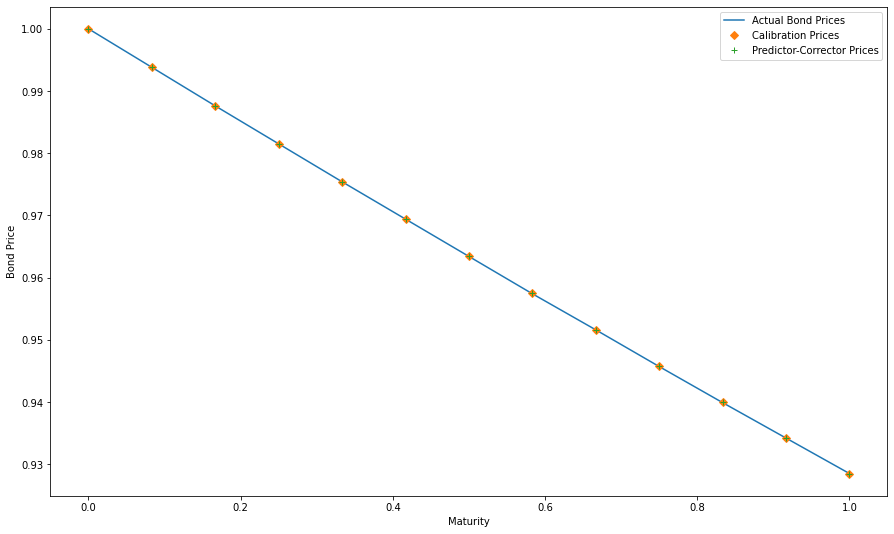

In [9]:
plt.subplots(figsize=(15, 9))
plt.plot(maturity, zcb_prices, label = 'Actual Bond Prices')
plt.plot(maturity, model_prices, 'D', label = 'Calibration Prices')
plt.plot(maturity, predcorr_price, '+',label = "Predictor-Corrector Prices")
plt.xlabel('Maturity')
plt.ylabel('Bond Price')
plt.legend()
plt.show()

In [10]:
def calc_vol_t_t_1(S_t, sigma, gamma):
    """Calculate the value of sigma(t, t+1)"""
    return sigma * S_t ** (gamma - 1)


def calc_price_t_1(S_t, r, sigma, gamma, delta_t, xi):
    """Calculate the value of price at t+1 using price at t"""
    sigma_t_t_1 = calc_vol_t_t_1(S_t, sigma, gamma)
    return S_t * np.exp((r - .5 * sigma_t_t_1 ** 2) * delta_t + sigma_t_t_1 * xi * np.sqrt(delta_t))


def calc_continuously_compounded_interest_rate(forward_rate, month, delta_t):
    """Calculate the continuously compounded interest rate using the forward rate, month and delta t"""
    return np.log(1 + forward_rate[month] * delta_t) / delta_t


def calc_combined_simulation(cycles=10):
    """Running the super combined simulations for cycles"""
    stock_paths = [None] * cycles
    firm_paths = [None] * cycles
    corr_matrix = np.linalg.cholesky(np.array([[1, corr_cp_stk], [corr_cp_stk, 1]]))

    for simulation_cycle in range(cycles): # Running through the cycles
        sim_cycle_stock_path = [None] * months
        sim_cycle_firm_path = [None] * months
        current_S = S0
        current_S_cp = S_cp
        
        for month in range(0, months): # Running through the entire length of option life in months step
            sim_cycle_stock_path[month] = current_S
            sim_cycle_firm_path[month] = current_S_cp
            xi = np.matmul(corr_matrix, norm.rvs(size=2))

            r = calc_continuously_compounded_interest_rate(forward_rate, month, delta_t)
            current_S = calc_price_t_1(current_S, r, v, gamma, delta_t, xi[0])
            current_S_cp = calc_price_t_1(current_S_cp, r, v_cp, gamma, delta_t, xi[1])

        # Saving the stock and firm path
        stock_paths[simulation_cycle] = sim_cycle_stock_path
        firm_paths[simulation_cycle] = sim_cycle_firm_path

    return stock_paths, firm_paths


In [11]:
# Firing the entire simulation
stock_paths, counterparty_firm_paths = calc_combined_simulation(cycles=100000)

In [12]:
print(f"Mean value of the stock path post the option time period: {np.mean(stock_paths)}")
print(f"Mean value of the counterparty firm value path post the option time period: {np.mean(counterparty_firm_paths)}")

Mean value of the stock path post the option time period: 103.48694807922315
Mean value of the counterparty firm value path post the option time period: 207.0046264411974


In [12]:
def plot_paths(paths, barrier_debt, text_barrier_debt, y_label, x_label, title):
    """Plotting the stock simulations"""

    months_to_plot = ["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9", "M10", "M11", "M12"]
    plt.subplots(figsize=(20, 10))
    paths = pd.DataFrame(paths, columns=months_to_plot)
    for _, row in paths.iterrows(): plt.plot(row, marker='o')

    plt.plot([barrier_debt] * len(months_to_plot), linestyle=':', color='r')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

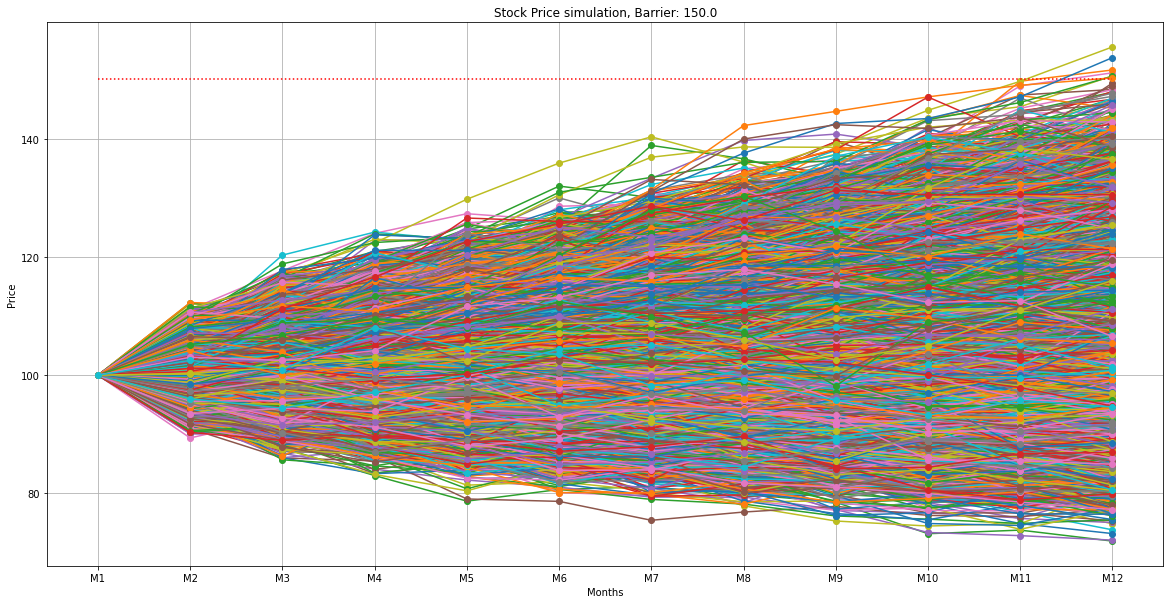

In [13]:
plot_paths(stock_paths, B_uo, "Barrier Up-and-Out", "Price", "Months", f"Stock Price simulation, Barrier: {B_uo}")


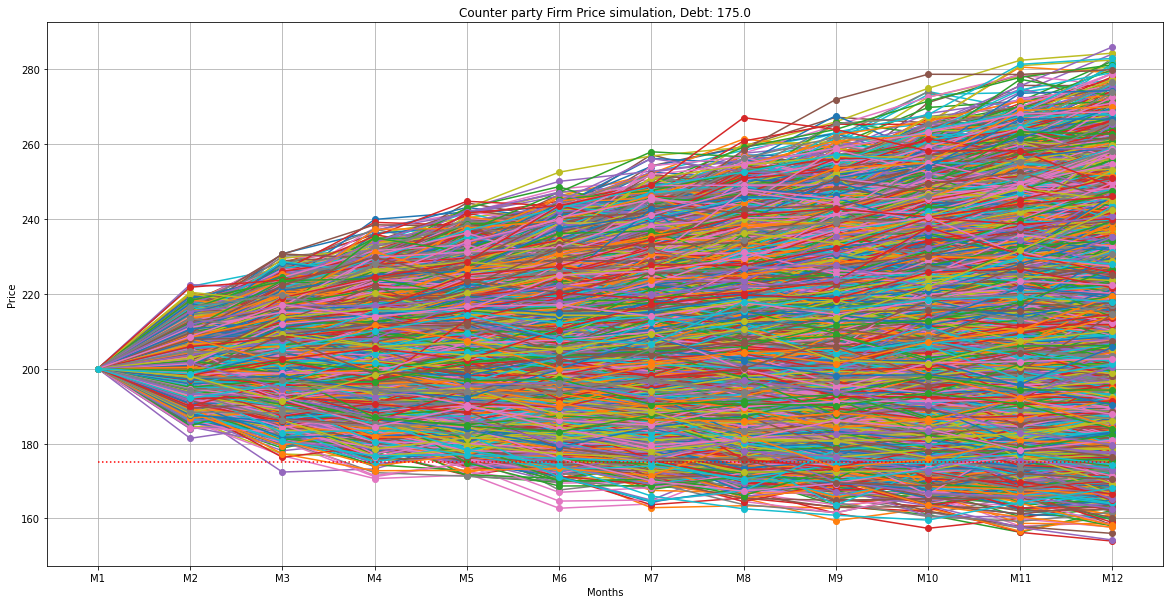

In [14]:
plot_paths(counterparty_firm_paths, K_cp, "Debt", "Price", "Months", f"Counter party Firm Price simulation, Debt: {K_cp}")


Q.2. Calculate the one-year discount factor which applies for each simulation, and use this to find first the value of the option for the jointly simulated stock and firm paths with no default risk, and then the value of the option with counterparty default risk

In [14]:
r_sim = np.log(1 + predcorr_forward*delta_t)/delta_t
r_sim

array([[0.07485693, 0.07614214, 0.07563986, ..., 0.07617244, 0.07575892,
        0.07601378],
       [0.07485693, 0.07506146, 0.07596397, ..., 0.07312996, 0.07361304,
        0.07432558],
       [0.07485693, 0.07551802, 0.07529863, ..., 0.07306912, 0.0727583 ,
        0.07312622],
       ...,
       [0.07485693, 0.07531839, 0.07573008, ..., 0.07713325, 0.07633884,
        0.075565  ],
       [0.07485693, 0.07383794, 0.07293879, ..., 0.07605531, 0.07660264,
        0.07606142],
       [0.07485693, 0.07374715, 0.07336699, ..., 0.07257093, 0.07347509,
        0.07459168]])

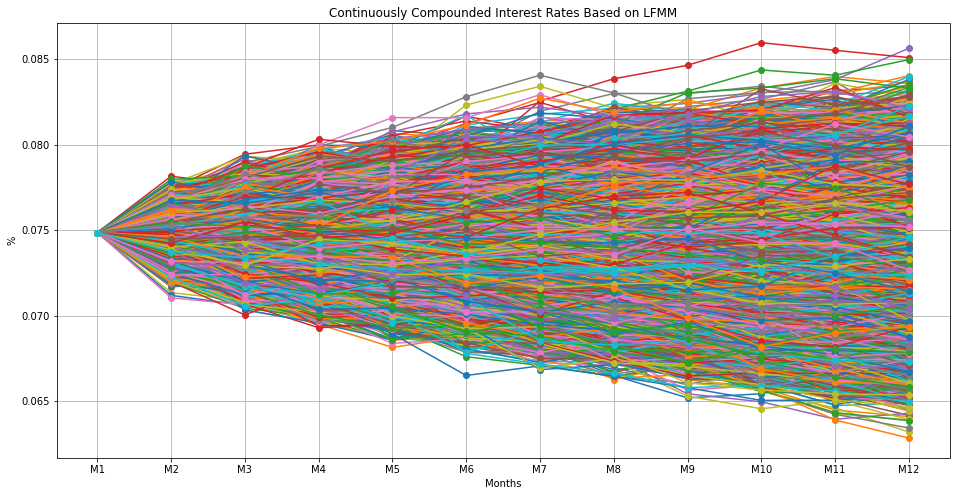

In [16]:
# Simulated interest rate plot
plt.subplots(figsize=(16, 8))
paths = pd.DataFrame(r_sim, columns = ["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9", "M10", "M11", "M12"])
for index, row in paths.iterrows():
    plt.plot(row, marker='o')

plt.title('Continuously Compounded Interest Rates Based on LFMM')
plt.xlabel('Months')
plt.ylabel('%')
plt.grid(True);

In [17]:
#One year discount factors
capfac_r_sim = np.cumprod(1 + delta_t*r_sim, axis = 1)
discfac_r_sim = capfac_r_sim**(-1)

discfac_1y = discfac_r_sim[:, -1]
discfac_1y

array([0.92701989, 0.92824836, 0.92847842, ..., 0.92666555, 0.9280432 ,
       0.92922043])

In [20]:
n = 100000

In [21]:
#default-free UAO call value
def uao_call_disc_payoffs(price_paths, discfacs, strike, barrier):
    disc_payoffs = np.zeros([n, 2])
    price_paths = np.array(price_paths)
    path_no = -1
    
    for path in price_paths:
        path_no += 1
        if sum((path >= barrier)) == 0:
            disc_payoffs[path_no, 0] = np.maximum(path[-1] - strike, 0) * discfacs[path_no]
            disc_payoffs[path_no, 1] = 1
            
    return disc_payoffs

disc_payoffs = uao_call_disc_payoffs(stock_paths, discfac_1y, K, B_uo)

In [22]:
uao_call_meanval = np.mean(np.extract(disc_payoffs[:, 1] == 1, disc_payoffs[:, 0]))
uao_call_stderr = np.std(np.extract(disc_payoffs[:, 1] == 1, disc_payoffs[:, 0]))/np.sqrt(np.sum(disc_payoffs[:, 1]))

print('Default-free European UAO Call Value:', uao_call_meanval.round(3))
print('Default-free European UAO Call Std. Error:', uao_call_stderr.round(3))

Default-free European UAO Call Value: 7.677
Default-free European UAO Call Std. Error: 0.023


In [25]:
#CVA estimate
Sf_T = np.column_stack((np.array(counterparty_firm_paths)[:, -1], disc_payoffs[:, 1]))

#We only calculate the loss for those price paths where the call is activated, i.e. barrier is not breached
loss = (np.extract(disc_payoffs[:, 1] == 1, disc_payoffs[:, 0]) * (np.extract(Sf_T[:, 1] == 1, Sf_T[:, 0]) < Debt) *
        (1 - rr))

cva_meanval = np.mean(loss)
cva_stderror = np.std(loss)/np.sqrt(np.sum(disc_payoffs[:, 1]))

print('CVA Mean Value:', cva_meanval.round(3))
print('CVA Std. Error:', cva_stderror.round(3))
print(' ')
print('Default-adj UAO Call Value:', (uao_call_meanval - cva_meanval).round(3))

CVA Mean Value: 0.015
CVA Std. Error: 0.001
 
Default-adj UAO Call Value: 7.662


Q.4. Suppose interest rates increased 25 basis points. What is the new value of your option?

In [26]:
r_sim_plus25bps = r_sim + 0.0025
r_sim_plus25bps

array([[0.07735693, 0.07864214, 0.07813986, ..., 0.07867244, 0.07825892,
        0.07851378],
       [0.07735693, 0.07756146, 0.07846397, ..., 0.07562996, 0.07611304,
        0.07682558],
       [0.07735693, 0.07801802, 0.07779863, ..., 0.07556912, 0.0752583 ,
        0.07562622],
       ...,
       [0.07735693, 0.07781839, 0.07823008, ..., 0.07963325, 0.07883884,
        0.078065  ],
       [0.07735693, 0.07633794, 0.07543879, ..., 0.07855531, 0.07910264,
        0.07856142],
       [0.07735693, 0.07624715, 0.07586699, ..., 0.07507093, 0.07597509,
        0.07709168]])

In [27]:
capfac_r_sim_plus25bps = np.cumprod(1 + delta_t*r_sim_plus25bps, axis = 1)
discfac_r_sim_plus25bps = capfac_r_sim_plus25bps**(-1)

discfac_1y_plus25bps = discfac_r_sim_plus25bps[:, -1]
discfac_1y_plus25bps

array([0.92472003, 0.9259452 , 0.92617464, ..., 0.92436664, 0.92574058,
       0.92691465])

In [28]:
#default-free UAO call value post interest rate increase
disc_payoffs_plus25bps = uao_call_disc_payoffs(stock_paths, discfac_1y_plus25bps, K, B_uo)

In [29]:
uao_call_meanval_plus25bps = np.mean(np.extract(disc_payoffs_plus25bps[:, 1] == 1, disc_payoffs_plus25bps[:, 0]))
uao_call_stderr_plus25bps = (np.std(np.extract(disc_payoffs_plus25bps[:, 1] == 1, disc_payoffs_plus25bps[:, 0]))/
                             np.sqrt(np.sum(disc_payoffs_plus25bps[:, 1])))

print('Default-free European UAO Call Value after Interest Rate Increase:', uao_call_meanval_plus25bps.round(3))
print('Default-free European UAO Call Std. Error after Interest Rate Increase:', uao_call_stderr_plus25bps.round(3))

Default-free European UAO Call Value after Interest Rate Increase: 7.658
Default-free European UAO Call Std. Error after Interest Rate Increase: 0.023


In [30]:
#default-adjusted UAO call value post interest rate increase
#CVA estimate
Sf_T_plus25bps = np.column_stack((np.array(counterparty_firm_paths)[:, -1], disc_payoffs_plus25bps[:, 1]))

#We only calculate the loss for those price paths where the call is activated, i.e. barrier is not breached
loss_plus25bps = (np.extract(disc_payoffs_plus25bps[:, 1] == 1, disc_payoffs_plus25bps[:, 0]) * 
                  (np.extract(Sf_T_plus25bps[:, 1] == 1, Sf_T_plus25bps[:, 0]) < Debt) * (1 - rr))

cva_meanval_plus25bps = np.mean(loss_plus25bps)
cva_stderror_plus25bps = np.std(loss_plus25bps)/np.sqrt(np.sum(disc_payoffs_plus25bps[:, 1]))

print('CVA Mean Value after Interest Rate Increase:', cva_meanval_plus25bps.round(3))
print('CVA Std. Error after Interest Rate Increase:', cva_stderror_plus25bps.round(3))
print(' ')
print('Default-adj UAO Call Value after Interest Rate Increase:', (uao_call_meanval_plus25bps - 
                                                                   cva_meanval_plus25bps).round(3))

CVA Mean Value after Interest Rate Increase: 0.015
CVA Std. Error after Interest Rate Increase: 0.001
 
Default-adj UAO Call Value after Interest Rate Increase: 7.643
